<a href="https://colab.research.google.com/github/Rushabh309/Sentimental-analysis-of-twitter-Data/blob/master/Twitter_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objective**

Sentimental Analysis of Twitter Dataset using Machine Learning 

# **Import**

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score

# **Upload Datasets**

In [2]:
train = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')
submission = pd.read_csv('sample_submission_gfvA5FD.csv')

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
submission.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [6]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [7]:
train['tweet'][786]

' @user what did you decide?   #fowoh #goldenretriever #lcck9comfodog #workingdog '

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# **Data Cleaning**

**Lemmatization** is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as same. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

In [9]:
stop_words = set(stopwords.words('english'))
stop = [x.lower() for x in stop_words]
lemma = WordNetLemmatizer()

shortcuts = {'u': 'you', 'y': 'why', 'r': 'are', 'doin': 'doing', 'hw': 'how', 'k': 'okay', 'm': 'am', 'b4': 'before',
            'idc': "i do not care", 'ty': 'thankyou', 'wlcm': 'welcome', 'bc': 'because', '<3': 'love', 'xoxo': 'love',
            'ttyl': 'talk to you later', 'gr8': 'great', 'bday': 'birthday', 'awsm': 'awesome', 'gud': 'good', 'h8': 'hate',
            'lv': 'love', 'dm': 'direct message', 'rt': 'retweet', 'wtf': 'hate', 'idgaf': 'hate',
             'irl': 'in real life', 'yolo': 'you only live once'}

def clean(text):
    text = text.lower()
    text = re.sub('\W+', ' ', text).strip()
    text = text.replace('user', '')
    text_token = word_tokenize(text)
   
    full_words = []
    for token in text_token:
        if token in shortcuts.keys():
            token = shortcuts[token]
        full_words.append(token)

    words_alpha = [re.sub(r'\d+', '', word) for word in full_words]
    words_big = [word for word in words_alpha if len(word)>2]
    stemmed_words = [lemma.lemmatize(word) for word in words_big]
    clean_text = " ".join(stemmed_words)
    clean_text = clean_text.replace('   ', ' ')
    clean_text = clean_text.replace('  ', ' ')
    return clean_text

# **numbers of Positive and racist/sexist tweets**

In [10]:
hypocrite = []
for i in range(len(train['tweet'])):
    if 'hypocrite' in train['tweet'][i]:
        if train['label'][i] == 1:
            hypocrite.append('racist')
        else:
            hypocrite.append('good')
    else:
        hypocrite.append('good')
df = pd.DataFrame(columns=['hypocrite'], data=hypocrite)
print(df['hypocrite'].value_counts())

train['hypocrite'] = hypocrite

good      31957
racist        5
Name: hypocrite, dtype: int64


In [11]:
train['combined'] = train['tweet'].apply(str) + ' ' + train['hypocrite'].apply(str)
train

,id,label,tweet,hypocrite,combined
0,1,0,@user when a father is dysfunctional and is s...,good,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...,good,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty,good,bihday your majesty good
3,4,0,#model i love u take with u all the time in ...,good,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,good,factsguide: society now #motivation good
...,...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,good,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...,good,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...,good,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...",good,"@user #sikh #temple vandalised in in #calgary,..."


In [12]:
X_train = train.combined
y = train.label
X_test = test.tweet

In [13]:
clean_Xtrain = X_train.apply(lambda x: clean(x))

In [14]:
clean_Xtrain[1531]

'last shot the hotel stayed this weekend back the grind grateful healthy funwreekend good'

In [15]:
clean_Xtest = X_test.apply(lambda x: clean(x))

In [16]:
print(len(clean_Xtrain))
print(len(clean_Xtest))
print(len(y))

31962
17197
31962


In [17]:
vectorizer = CountVectorizer(max_df=0.5)

X = vectorizer.fit_transform(clean_Xtrain)
X_test = vectorizer.transform(clean_Xtest)

In [18]:
print(X.shape)
print(X_test.shape)

(31962, 37184)
(17197, 37184)


In [19]:
train.head()

,id,label,tweet,hypocrite,combined
0,1,0,@user when a father is dysfunctional and is s...,good,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...,good,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty,good,bihday your majesty good
3,4,0,#model i love u take with u all the time in ...,good,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,good,factsguide: society now #motivation good


# **A) Understanding the common words used in the tweets: WordCloud**

In [20]:
combi = train.append(test, ignore_index=True)

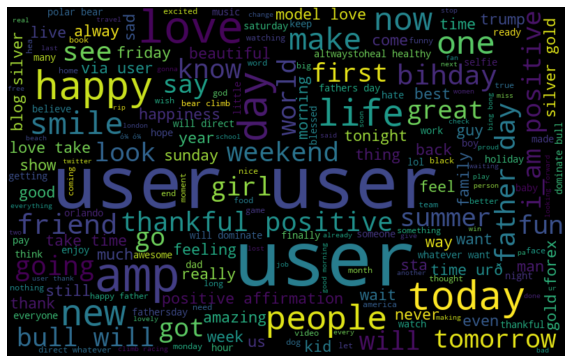

In [21]:
all_words = ' '.join([text for text in combi['tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# **B) Words in non racist/sexist tweets**

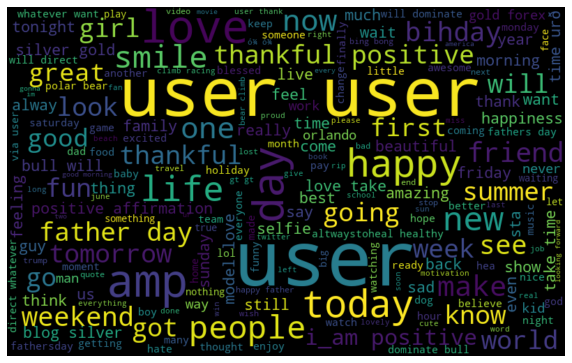

In [22]:
normal_words =' '.join([text for text in combi['tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# **C) Racist/Sexist Tweets**

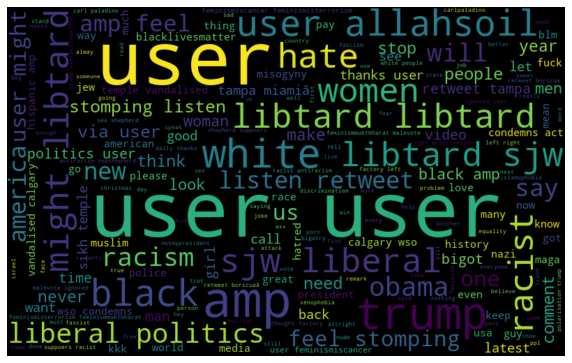

In [23]:
negative_words = ' '.join([text for text in combi['tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# **Desicion using Linear SVC model**

**SVM** is a supervised machine learning algorithm that can be used for classification or regression problems. It uses a technique called the kernel trick to transform your data and then based on these transformations it finds an optimal boundary between the possible outputs.

The objective of a **Linear SVC** (Support Vector Classifier) is to fit the data you provide, returning a “best fit” hyperplane that divides, or categorizes your data. From there, after getting the hyperplane, you can then feed some features to your classifier to see what the “predicted” class is.


In [24]:
model = LinearSVC(penalty='l2', C=0.5, dual=False, random_state=0, max_iter=1000)
print(model)

LinearSVC(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)

model.fit(X_train,y_train)
y_pred = model.predict(X_val)
print('Accuracy:', accuracy_score(y_pred, y_val))
print("F1 Score: ", f1_score(y_pred, y_val))

Accuracy: 0.9648052557484749
F1 Score:  0.6905089408528199


In [26]:
from sklearn.metrics import classification_report
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

The **Classification Report** shows a representation of the main classification metrics on a per-class basis. This gives a deeper intuition of the classifier behavior over global accuracy which can mask functional weaknesses in one class of a multiclass problem.

In [27]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5985
           1       0.75      0.62      0.68       408

    accuracy                           0.96      6393
   macro avg       0.86      0.80      0.83      6393
weighted avg       0.96      0.96      0.96      6393



# **Highest Accuracy with Linear SVC 0.9648052557484749**

In [28]:
df = pd.DataFrame()
df['y_pred'] = y_pred
df['y_pred'].value_counts()

0    6057
1     336
Name: y_pred, dtype: int64

In [29]:
model.fit(X, y)
y_pred = model.predict(X_test)

# **Total numbers of Positive and racist/sexist tweets**

In [30]:
df = pd.DataFrame()
df['y_pred'] = y_pred
df['y_pred'].value_counts()

0    16205
1      992
Name: y_pred, dtype: int64